# 04. PyTorch Custom Datasets Notebook

We've used some datasets with PyTorch before.

But how do you get your own data into PyTorch?

One of the ways to do so is via: custom datasets.

## Domain libraries

Depending on what you're working on, vision, text, audio, recommendation, you'll want to look into each of the PyTorch domain librarires for existing data loading functions and customizable data loading functions.

## 0. Importing PyTorch and setting up device-agnostic code


In [77]:
import torch
from torch import nn

# Note: PyTorch 1.10.0+ is required for this course
torch.__version__

'1.12.1+cu102'

In [78]:
# setup device-agnostic code
device = "cude" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [79]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


## 1. Get data

Our dataset is a sbuset of Food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing).

Our dataset starts with 3 classes of food and only 10% of the images (~75 training, 25 testing).

Why do this?

When starting our ML projects, it's important to try things on a small scale when necessary.

The whole point is to speed up how fast you can experiment.

In [80]:
import requests
import zipfile
from pathlib import Path

#setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# if the image doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory already exists, skipping download")
else:
  print(f"{image_path} directory does not exist, downloading and unzipping")
  image_path.mkdir(parents=True, exist_ok=True)

# download data
  with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak,sushi data...")
    f.write(request.content)

# unzip data
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping...")
  zip_ref.extractall(image_path)


data/pizza_steak_sushi directory already exists, skipping download
Unzipping...


In [81]:
image_path

PosixPath('data/pizza_steak_sushi')

## 2. Becoming one with the data (data preparation and data exploration)

In [82]:
import os
def walk_thorugh_dir(dir_path):
  """ Walks through dir_path returning its contents"""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [83]:
walk_thorugh_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.


In [84]:
# Setup training and test data directories (paths)
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2. Visualizing and image

Let's write some code to:
1. Get all of the image paths
2. Pick a random image path using Python's `random.choice()`
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python's `PIL`
5. We'll then show the image and print the metadata

data/pizza_steak_sushi/train/pizza/1968947.jpg
pizza
Random image path: data/pizza_steak_sushi/train/pizza/1968947.jpg
Random image class: pizza
Random image height: 512
Random image width: 512


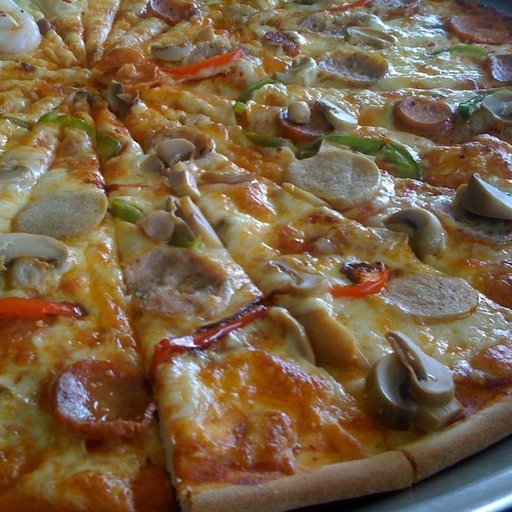

In [85]:
import random
from PIL import Image

# set seed
#random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get the image class from path name (the image class of the directory where the image is)
image_class = random_image_path.parent.stem
print(image_class)

# 4. open the image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Random image class: {image_class}")
print(f"Random image height: {img.height}")
print(f"Random image width: {img.width}")
img

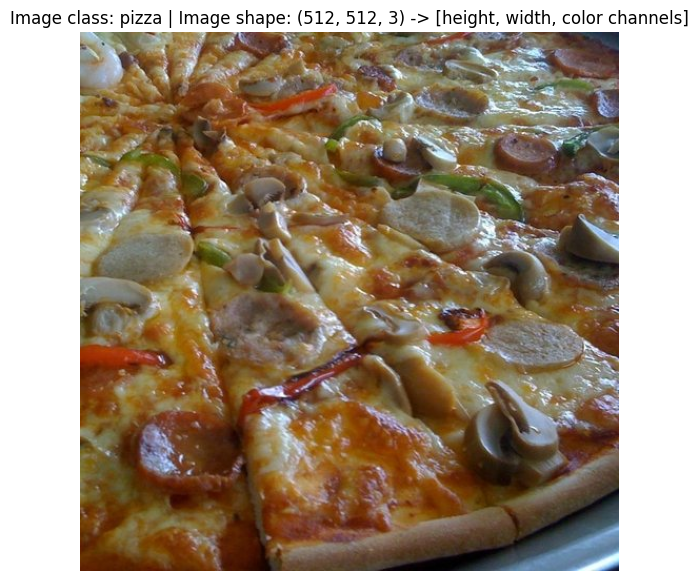

In [86]:
import numpy as np
import matplotlib.pyplot as plt 

# Turn the image into an arrary
img_as_array = np.array(img)

# plot the image with matplot lib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color channels]")
plt.axis(False);

In [87]:
img_as_array

array([[[172, 181, 176],
        [172, 183, 177],
        [173, 186, 179],
        ...,
        [ 33,  39,  61],
        [ 30,  38,  61],
        [ 28,  39,  61]],

       [[169, 178, 173],
        [170, 181, 175],
        [172, 185, 178],
        ...,
        [ 34,  40,  62],
        [ 30,  41,  63],
        [ 30,  41,  63]],

       [[170, 176, 172],
        [171, 180, 175],
        [173, 184, 180],
        ...,
        [ 32,  40,  59],
        [ 29,  40,  60],
        [ 29,  42,  61]],

       ...,

       [[ 92,  31,   2],
        [ 93,  32,   3],
        [ 94,  33,   2],
        ...,
        [ 18,  34,  67],
        [ 16,  29,  61],
        [ 15,  29,  58]],

       [[ 92,  31,   2],
        [ 93,  32,   3],
        [ 94,  33,   4],
        ...,
        [ 15,  25,  52],
        [ 13,  23,  48],
        [ 14,  24,  49]],

       [[ 93,  32,   3],
        [ 93,  32,   3],
        [ 93,  32,   3],
        ...,
        [ 18,  24,  48],
        [ 13,  21,  42],
        [ 13,  21,  42]]

## 3. Transforming data

Before we can use our image with PyTorch:
1. Turn your target data into tensors (in our case, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`.


In [88]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

In [89]:
# write a transform for image
data_transform = transforms.Compose([
  # Resize our images to 64x64 pixels
  transforms.Resize((64,64)),
  # flip the images randomly on the horizontal axis
  transforms.RandomHorizontalFlip(p=0.5),
  # turn the image into a PyTorch tensor
  transforms.ToTensor()
])

In [90]:
data_transform(img).shape

torch.Size([3, 64, 64])

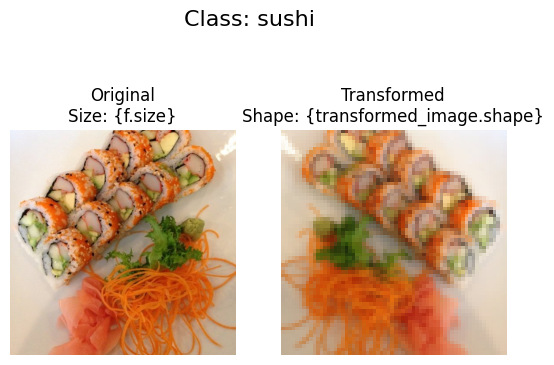

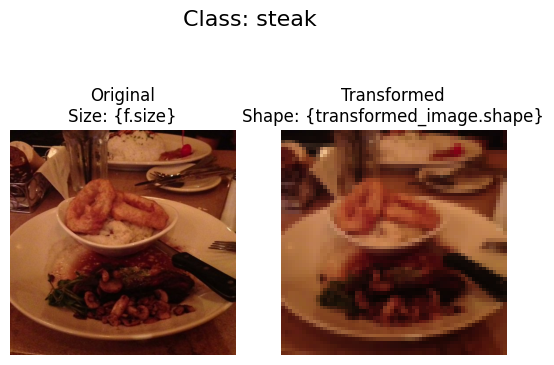

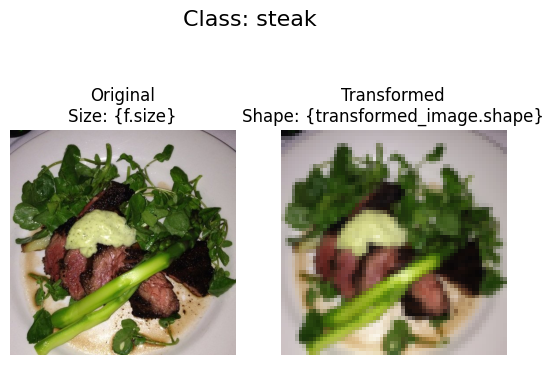

In [91]:
def plot_transformed_images(image_paths, transform, n=3,seed=42):
  """selects random images from a path of images and loads/transforms them then plots the original vs transformed version"""
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows = 1, ncols =2)
      ax[0].imshow(f)
      ax[0].set_title("Original\nSize: {f.size}")
      ax[0].axis(False)

      # transform the image and plot it
      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title("Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize = 16)

plot_transformed_images(image_paths=image_path_list, transform=data_transform,
                        n=3, seed=42)


## 4.1 Option 1: Loading image using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`

In [92]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the labels/targets

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [93]:
# Gets the names as lists
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [94]:
# Get the class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [95]:
# check the lengths of our data
len(train_data), len(test_data)

(225, 75)

In [96]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [97]:
# Index on the train_data dataset to get a singhle image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"label datatype: {type(label)}")


Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> [color channels, height, width]
Permuted shape: torch.Size([64, 64, 3]) -> [height, width, color channels]


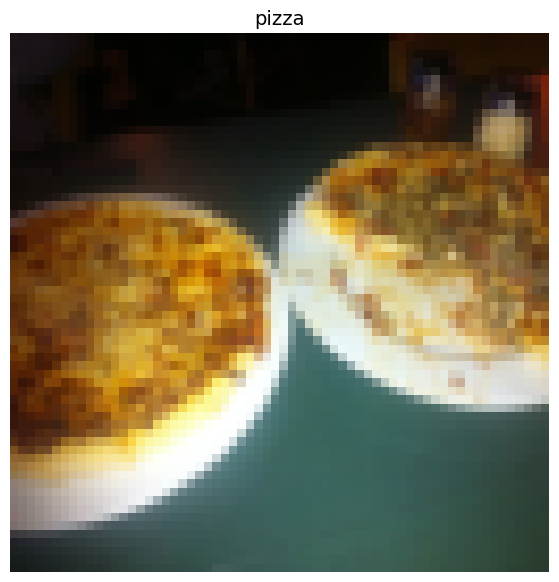

In [98]:
# Rearrange the order dimensions
img_permute = img.permute(1,2,0)

# Print our different shapes
print(f"Original shape: {img.shape} -> [color channels, height, width]")
print(f"Permuted shape: {img_permute.shape} -> [height, width, color channels]")

# Plot the image with permuted dimensions
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=14);

### 4.1 Turn loaded images into `DataLoader`'s

A `DataLoader` is going to help us turn our `Dataset`'s into iterables and we can customise the `batch_size` so our model can see `batch_size` images at a time

In [99]:
# Turn train and test datasets into DataLoader(s)
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              num_workers=4,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                              batch_size = BATCH_SIZE,
                              num_workers=4,
                              shuffle = False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f188c22e830>,
 <torch.utils.data.dataloader.DataLoader at 0x7f188c22e920>)

Our lengths or dataloaders are same as of our datasets because we are using BATCH_SIZE = 1

In [100]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [101]:
img, label = next(iter(train_dataloader))

# BATCH size will now be 1, you can change the BATCH size if you like
print(f"Image shape: {img.shape} -> [batch size, color channels, height, width]")
print(f"Image label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch size, color channels, height, width]
Image label shape: torch.Size([1])


## 5. Option 2: Loading image data with a custom `Dataset`

1. Want to be able to load images from file
2. want to be able to get class names from the Dataset
3. want to be able to get classes as dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-build `Dataset` functions

Cons:
* Even though you could create a `Dataset` out of almost anything, it doesn't mean it will work...
* Using a custom `Dataset` often results in us writing more code, which could be prone to errors or performance issues.

In [102]:
import os
import pathlib
import torch


from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [103]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 creating a helper function to get class names

We want to function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't fround (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dict and a list and return them.

In [104]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")


# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [105]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory"""
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"couldn't find any classes in {directory}... please check the file structure.")
  
  # 3. Create a dictionary of index labels (computer prefer numbers rather than strings as labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

  return classes, class_to_idx

In [106]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a tarnsform if we'd like to transform our data.
3. Create several attributes:
  * paths - transform we'd like to use
  * transform - the transform we'd like to use
  * classes - a list of the target classes
  * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len__()` method to return the length of our dataset
6. overwrite the `__getitem__()` method to return a given sample when passes an index


In [107]:
# Write a custom dataset class 
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset 
  def __init__(self, targ_dir: str, transform=None):
    # 3. create class attributes
    # get all the images paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # Setup transforms
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self, index: int) -> Image.Image:
    """Opens an image via a path and returns it."""
    image_path = self.paths[index]
    return Image.open(image_path)
  # 5. overwrite __len__()
  def __len__(self) -> int:
    """returns the total number of samples."""
    return len(self.paths)
  
  # 6. overwrite __getitem__()
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    """Gets a sample from the dataset at a given index and returns it."""
    # Load the image
    img = self.load_image(index)
    # Get the image class
    class_name = self.paths[index].parent.name
    # Turn the class name into a label
    class_idx = self.class_to_idx[class_name]
    # Apply the transforms (if any)
    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

In [108]:
# Create a transform
from torchvision import transforms
train_transforms = transforms.Compose([
  transforms.Resize((64,64)),
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.ToTensor()
])

test_transforms = transforms.Compose([
  transforms.Resize((64,64)),
  transforms.ToTensor()
])

In [109]:
# Test out ImageFolderCustom

train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                      transform=test_transforms)

In [110]:
train_data_custom, test_data_custom 

(<__main__.ImageFolderCustom at 0x7f1883fb5570>,
 <__main__.ImageFolderCustom at 0x7f1883fb4430>)

In [111]:
len(train_data), len(train_data_custom)

(225, 225)

In [112]:
len(test_data), len(test_data_custom)

(75, 75)

In [113]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [114]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustomDataset
print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibiity
4. Get a list of random sample indexes from the target dataset.
5. setup a matplotlib plot.
6. Loop through the random samples images and plot them with matplotlib.
7. Make sure the dimensions of our images line up with matplotlib(HWC)

In [115]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int =10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. adjust the display if n is too high
  if n>10:
    n=10
    display_shape = False
    print(f"For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. set the random seed
  if seed:
      random.seed(seed)

    # 4. Get random samples indexes
  random_sample_idx = random.sample(range(len(dataset)), k=n)

    # 5. setup plot
  plt.figure(figsize=(16,8))

    # 6. Loop through random indexes and plot them with matplotlib
  for i, targ_samples in enumerate(random_sample_idx):
      targ_image, targ_label = dataset[targ_samples][0], dataset[targ_samples][1]

      # 7. adjust tensor dimensions for plotting
      targ_image_adjust = targ_image.permute(1,2,0)

      # plot adjusted samples
      plt.subplot(1,n,i+1)
      plt.imshow(targ_image_adjust)
      plt.axis(False)
      if classes:
        title = f"class: {classes[targ_label]}"
        if display_shape:
          title = title + f"\nshape: {targ_image_adjust.shape}"

      plt.title(title)

In [116]:
random.sample(range(len(train_data_custom)), k=10)

[62, 57, 35, 188, 26, 173, 189, 139, 22, 151]

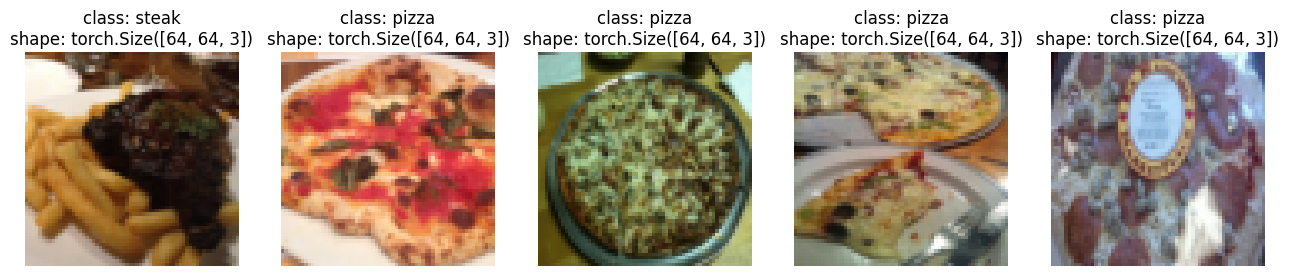

In [117]:
# display random images from the ImageFolder dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

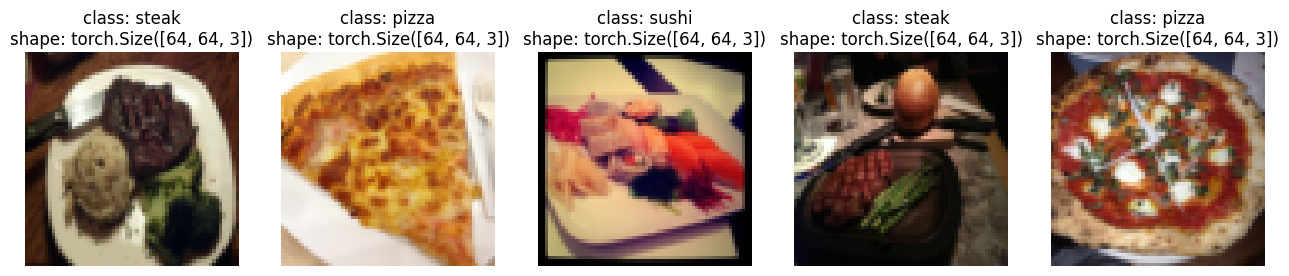

In [118]:
# Display random images from the ImageFolderCustom dataset
display_random_images(train_data_custom,
                      n=5,
                      classes=class_names,
                      seed=None)


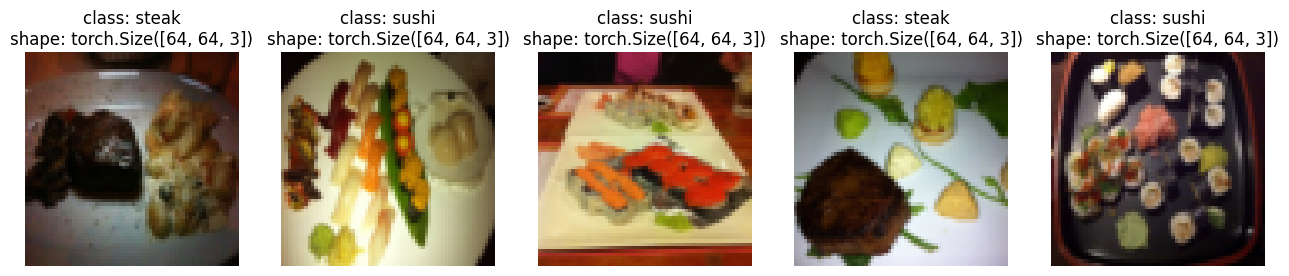

In [119]:
display_random_images(test_data,
                      n=5,
                      classes=class_names,
                      seed=None)

### 5.4 Turn custom loaded images into `DataLoader`

In [120]:
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                      batch_size=BATCH_SIZE,
                                      num_workers=NUM_WORKERS,
                                      shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                      batch_size=BATCH_SIZE,
                                      num_workers=NUM_WORKERS,
                                      shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f1883f5f880>,
 <torch.utils.data.dataloader.DataLoader at 0x7f1883f5c310>)

In [121]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transforms (data augmentation)

Data augmentation is the process of artificially adding diversity to your training data.

In case of image data, this may mean applying various image transformations to the training images.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels...

In [122]:
# let's look at trivailaugment 
from torchvision import transforms

train_transforms = transforms.Compose([
  transforms.Resize(size = (224,224)),
  transforms.TrivialAugmentWide(num_magnitude_bins=31),
  transforms.ToTensor()
])

test_transforms = transforms.Compose([
  transforms.Resize(size = (224,224)),
  transforms.ToTensor()
])



In [123]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/steak/354513.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3424937.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/690177.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1868005.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/2144308.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1016217.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/502076.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/2117351.jpg')]

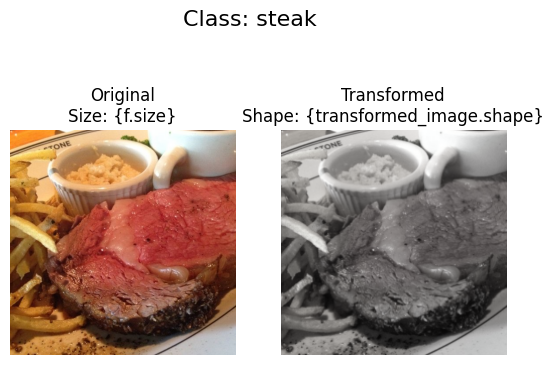

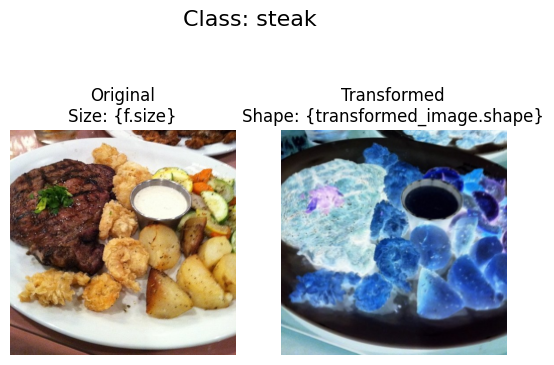

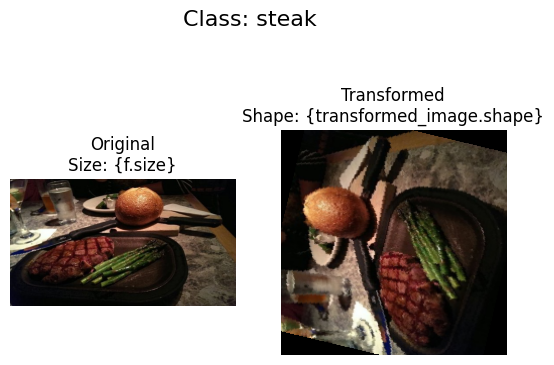

In [124]:
# Plot random transformed images
plot_transformed_images(
  image_paths=image_path_list,
  transform=train_transforms,
  n=3,
  seed = None
)

## 7. Model 0: TinyVGG without data augmentation

Let's replicate TinyVGG architecture from the CNN Explainer website

### 7.1 Creating transforms and loading data for Model 0

In [125]:
# Create a simple transform
simple_transform = transforms.Compose([
  transforms.Resize((64,64)),
  transforms.ToTensor()
])


In [126]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform = simple_transform)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform = simple_transform)

train_data_simple, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ))

In [127]:
# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

# setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoaders
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                      batch_size=BATCH_SIZE,
                                      num_workers=NUM_WORKERS,
                                      shuffle=True)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                      batch_size=BATCH_SIZE,
                                      num_workers=NUM_WORKERS,
                                      shuffle=False)

In [128]:
NUM_WORKERS

4

### 7.2 Create TinyVGG model class

In [129]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN Explainer
  """

  def __init__(self, 
               input_shape : int,
               hidden_units : int,
               output_shape : int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
      nn.Conv2d(in_channels =input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2,
                   stride=2) # default stride value is same as kernel_size
    )
    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(in_channels =hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2,
                   stride=2) # default stride value is same as kernel_size
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x
    
    # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # same as above but in one line but this one benifits from operatore fusion



In [130]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image ( to tese the model)

In [131]:
# get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [132]:
# Try a forward pass
model_0(image_batch)

tensor([[ 0.0202, -0.0022,  0.0100],
        [ 0.0186,  0.0031,  0.0064],
        [ 0.0185,  0.0011,  0.0090],
        [ 0.0248, -0.0038,  0.0093],
        [ 0.0191,  0.0009,  0.0103],
        [ 0.0208,  0.0020,  0.0050],
        [ 0.0219,  0.0006,  0.0124],
        [ 0.0214, -0.0023,  0.0095],
        [ 0.0249, -0.0045,  0.0082],
        [ 0.0194, -0.0005,  0.0110],
        [ 0.0226, -0.0009,  0.0091],
        [ 0.0220, -0.0020,  0.0097],
        [ 0.0213, -0.0043,  0.0082],
        [ 0.0229, -0.0009,  0.0100],
        [ 0.0212, -0.0046,  0.0090],
        [ 0.0217, -0.0041,  0.0101],
        [ 0.0217, -0.0052,  0.0109],
        [ 0.0214, -0.0016,  0.0084],
        [ 0.0200, -0.0001,  0.0087],
        [ 0.0189,  0.0014,  0.0081],
        [ 0.0201,  0.0015,  0.0086],
        [ 0.0198, -0.0036,  0.0102],
        [ 0.0221, -0.0002,  0.0084],
        [ 0.0241, -0.0026,  0.0095],
        [ 0.0218, -0.0022,  0.0087],
        [ 0.0178,  0.0026,  0.0075],
        [ 0.0213, -0.0018,  0.0084],
 

In [133]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size = [1,3,64,64])


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 31, 31]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 62, 62]           910
│    └─ReLU: 2-4                         [1, 10, 62, 62]           --
│    └─MaxPool2d: 2-5                    [1, 10, 31, 31]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 29, 29]           910
│    └─ReLU: 2-7                         [1, 10, 29, 29]           --
│    └─Conv2d: 2-8                       [1, 10, 27, 27]           910
│    └─ReLU: 2-9                         [1, 10, 27, 27]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [134]:
torchinfo.__version__

'1.8.0'

### 7.5 Create train and test loops functions

* `train_step()` - takes in a model and dataloader and trains the model on the dataloader.
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader.

In [135]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device = device):
  # Put the model in train mode
  model.train()

  # setup train loss and train_accuracy values
  train_loss, train_acc = 0,0

  # Loop through the data loader data batches
  for batc, (X, y) in enumerate(dataloader):
    # Send data to the target device
    X, y = X.to(device), y.to(device)

    # 1. forward pass
    y_pred = model(X)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. backward pass
    loss.backward()

    # 5. step the optimizer
    optimizer.step()

    # Calculate the training accuracy
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim = 1)
    train_acc += (y_pred_class == y).sum().item() / len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc
  

In [136]:
# Create a test step function
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device = device):
  # Put the model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0,0

  # Turn on inference mode (turns off gradients)
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X,y) in enumerate(dataloader):
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. forward pass
      test_pred_logits = model(X)

      # 2. Calculate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate the test accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)

      test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()` functions

In [137]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloader
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device = device):
  # 2. create an empty result dictionary 
  results = {"train_loss":[],
              "train_acc":[],
              "test_loss":[],
              "test_acc":[]}
  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model = model,
                                       dataloader = train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model = model,
                                    dataloader = test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)
    # 4.print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss: .4f} | Train acc: {train_acc: .4f} | Test loss: {test_loss: .4f} | Test acc: {test_acc: .4f}")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # 6. Return the filled results dictionary
  return results

### 7.7 Train and evaluate model_0

In [138]:
# set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set the no. of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

# setup a loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(),
                             lr = 0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train the model
model_0_results = train(model = model_0,
                        train_dataloader = train_dataloader_simple,
                        test_dataloader = test_dataloader_simple,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS,
                        device = device)
# ENd the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time - start_time: .3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss:  0.1370 | Train acc:  0.0586 | Test loss:  1.1102 | Test acc:  0.2604
Epoch: 1 | Train loss:  0.1366 | Train acc:  0.0469 | Test loss:  1.1359 | Test acc:  0.2604
Epoch: 2 | Train loss:  0.1390 | Train acc:  0.0391 | Test loss:  1.1420 | Test acc:  0.2604
Epoch: 3 | Train loss:  0.1346 | Train acc:  0.0508 | Test loss:  1.1561 | Test acc:  0.2604
Epoch: 4 | Train loss:  0.1399 | Train acc:  0.0312 | Test loss:  1.1604 | Test acc:  0.2604
Total training time:  2.901 seconds


In [139]:
model_0_results

{'train_loss': [0.13697130978107452,
  0.1365976780653,
  0.13895566761493683,
  0.1345706284046173,
  0.13992518186569214],
 'train_acc': [0.05859375, 0.046875, 0.0390625, 0.05078125, 0.03125],
 'test_loss': [1.1102389097213745,
  1.1358681917190552,
  1.1419823169708252,
  1.1561231017112732,
  1.1603959600130718],
 'test_acc': [0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667]}

### 7.8 Plot thr loss curves of model_0

A **loss curve** is a way of tracking your model's progress over time.

In [140]:
# get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [141]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of a result's dictionary"""
  # get the loss values of the results dictionary (training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # get the accuracy values of the results dictionary (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # figure out how many epochs there were 
  epochs = range(len(results["train_loss"]))

  # setup a plot
  plt.figure(figsize=(15,7))
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # plot the accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label = " train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();



/tmp/ipykernel_1970/833517744.py:23: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,2)


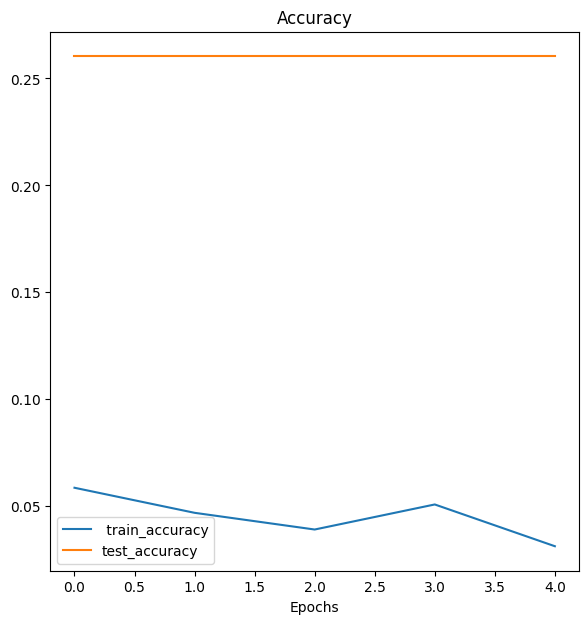

In [142]:
plot_loss_curves(model_0_results)